In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.seasonal import seasonal_decompose
from keras.preprocessing.sequence import TimeseriesGenerator

In [2]:
df = pd.read_csv("./data/Alcohol_Sales.csv", index_col='DATE', parse_dates=True)
df.index.freq = 'MS'  # index의 frequency를 Month Start로 조정
df.head()

,S4248SM144NCEN
DATE,
1992-01-01,3459
1992-02-01,3458
1992-03-01,4002
1992-04-01,4564
1992-05-01,4221


<Axes: xlabel='DATE'>

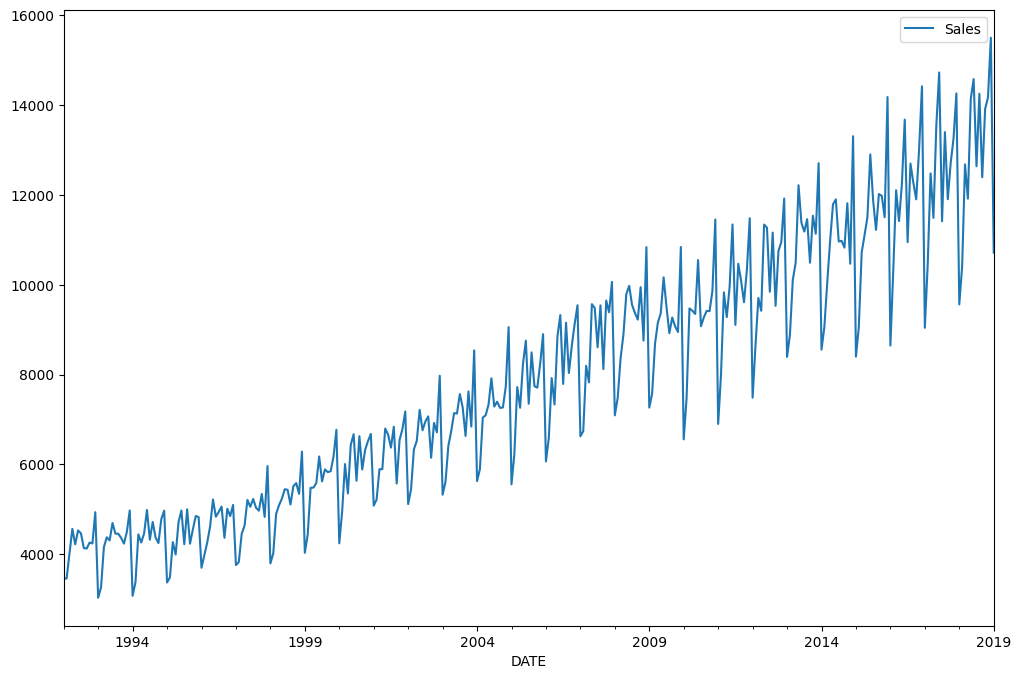

In [3]:
df.columns = ['Sales']
df.plot(figsize=(12, 8))

In [4]:
results = seasonal_decompose(df['Sales'])

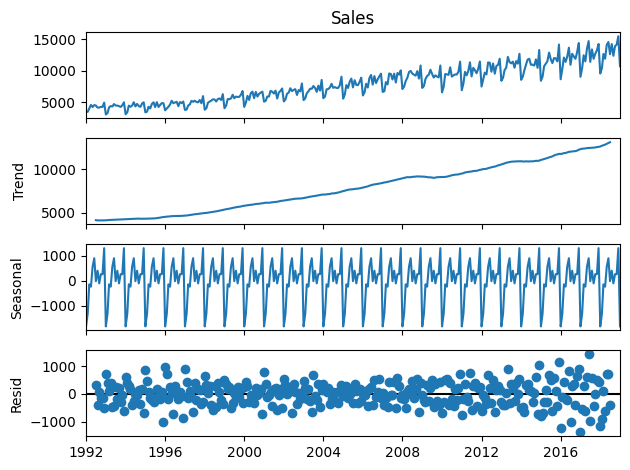

In [5]:
results.plot();

<Axes: xlabel='DATE'>

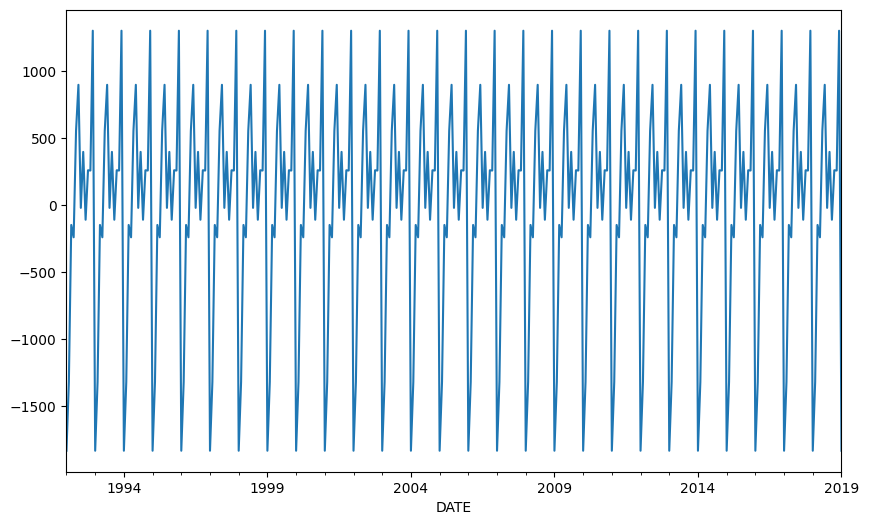

In [6]:
results.seasonal.plot(figsize=(10, 6))

In [7]:
len(df)

325

In [8]:
train = df.iloc[:313]
test = df.iloc[313:]

In [9]:
len(test)

12

In [10]:
scaler = MinMaxScaler()

In [11]:
scaler.fit(train)

MinMaxScaler()

In [12]:
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

In [13]:
n_input = 12
n_features = 1

train_generator = TimeseriesGenerator(
    data=scaled_train,  # 리스트 또는 ndarray와 같이 인덱싱이 가능한 2D데이터
    targets=scaled_train,  # data의 시간 단계와 상응하는 목표값으로 0번째 축의 길이가 data와 같아야한다.
    length=n_input,  # time steps
    batch_size=1  # batch size
    )

In [14]:
model = Sequential()
model.add(LSTM(150, activation="relu", input_shape=(n_input, n_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(150, activation="relu", return_sequences=False))
model.add(Dense(1))

model.compile(optimizer=Adam(learning_rate=0.001), loss="mse")

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 12, 150)           91200     
                                                                 
 dropout (Dropout)           (None, 12, 150)           0         
                                                                 
 lstm_1 (LSTM)               (None, 150)               180600    
                                                                 
 dense (Dense)               (None, 1)                 151       
                                                                 
Total params: 271,951
Trainable params: 271,951
Non-trainable params: 0
_________________________________________________________________


In [16]:
model.fit(train_generator, epochs=50)

Epoch 1/50
301/301 [==============================] - 2s 3ms/step - loss: 0.0170
Epoch 2/50
301/301 [==============================] - 1s 4ms/step - loss: 0.0089
Epoch 3/50
301/301 [==============================] - 1s 4ms/step - loss: 0.0081
Epoch 4/50
301/301 [==============================] - 1s 4ms/step - loss: 0.0075
Epoch 5/50
301/301 [==============================] - 1s 3ms/step - loss: 0.0045
Epoch 6/50
301/301 [==============================] - 1s 3ms/step - loss: 0.0033
Epoch 7/50
301/301 [==============================] - 1s 3ms/step - loss: 0.0028
Epoch 8/50
301/301 [==============================] - 1s 3ms/step - loss: 0.0029
Epoch 9/50
301/301 [==============================] - 1s 3ms/step - loss: 0.0024
Epoch 10/50
301/301 [==============================] - 1s 3ms/step - loss: 0.0023
Epoch 11/50
301/301 [==============================] - 1s 3ms/step - loss: 0.0024
Epoch 12/50
301/301 [==============================] - 1s 3ms/step - loss: 0.0027
Epoch 13/50
301/301 [====

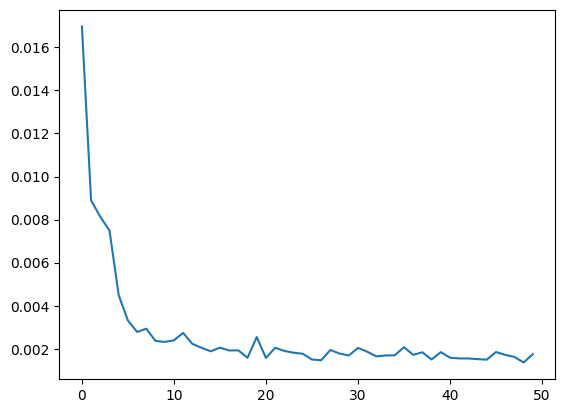

In [17]:
loss_values = model.history.history['loss']
plt.plot(range(len(loss_values)), loss_values)

In [18]:
first_eval_batch = scaled_train[-n_input:]
first_eval_batch

array([[0.63432772],
       [0.80776135],
       [0.72313873],
       [0.89870929],
       [1.        ],
       [0.71672793],
       [0.88648602],
       [0.75869732],
       [0.82742115],
       [0.87443371],
       [0.96025301],
       [0.5584238 ]])

In [19]:
first_eval_batch = first_eval_batch.reshape((1, n_input, n_features))

In [20]:
model.predict(first_eval_batch)

1/1 [==============================] - 0s 159ms/step


array([[0.7386505]], dtype=float32)

In [21]:
test_predictions = []

first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

In [22]:
for i in range(len(test)):
    current_pred = model.predict(current_batch)[0]
    test_predictions.append(current_pred)
    current_batch = np.append(current_batch[:, 1:, :], [[current_pred]], axis=1)

1/1 [==============================] - 0s 12ms/step


In [23]:
true_predictions = scaler.inverse_transform(test_predictions)
true_predictions

array([[11672.47220856],
       [13181.57078266],
       [12737.84710002],
       [14572.81689   ],
       [15007.08219552],
       [12655.62253523],
       [13984.18632334],
       [12932.18523127],
       [13648.53457093],
       [14278.67628402],
       [14675.26009566],
       [10802.94095087]])

In [24]:
test['Predictions'] = true_predictions

C:\Users\signlab_039\AppData\Local\Temp\ipykernel_27760\4269337381.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Predictions'] = true_predictions


<Axes: xlabel='DATE'>

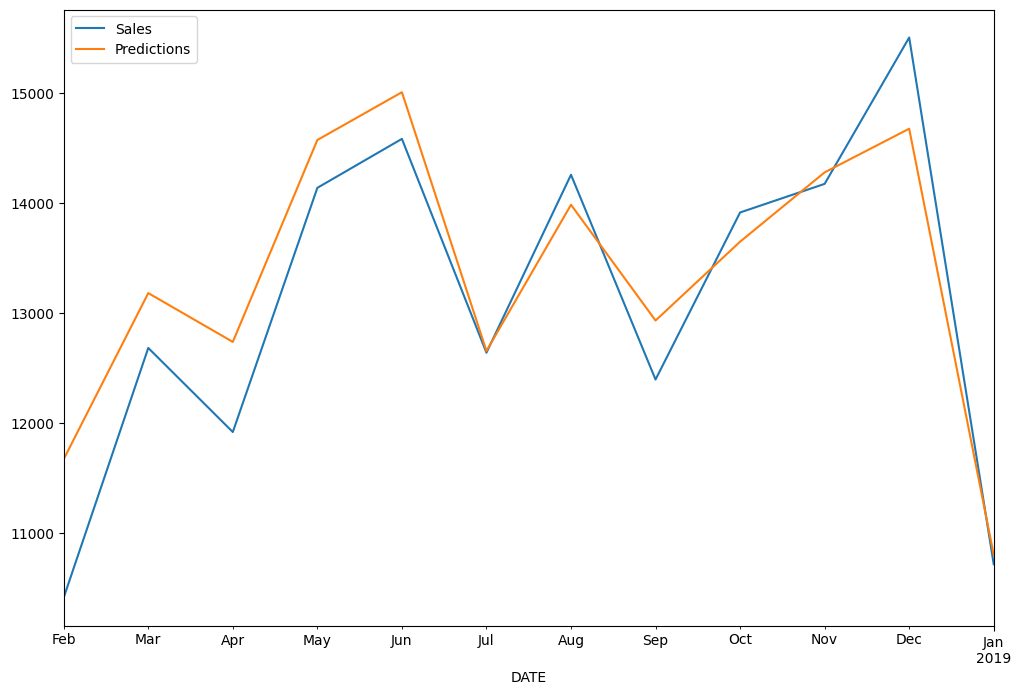

In [25]:
test.plot(figsize=(12, 8))